





































































































































































# Amazon RDS Bitcoin API

This notebook demonstrates how to interact with Amazon RDS for Bitcoin price data processing. It covers:

- Connecting to an Amazon RDS PostgreSQL instance.
- Creating database tables for Bitcoin price data.
- Fetching real-time Bitcoin data from CoinGecko API.
- Storing and retrieving Bitcoin data from the database.
- Performing time series analysis on the stored data.



*Utility Functions*  

bitcoin_rds_utils.py module connects these services by:
- Managing database connections and schema
- Fetching data from CoinGecko
- Processing and storing data in RDS
- Providing analysis functions for the stored data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Import your utility functions
import bitcoin_rds_utils as brds

# Configure basic logging 
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
_LOG = logging.getLogger(__name__)

Check if the enviroment variables (RDS and API key) are loaded properly

In [3]:
import os
from dotenv import load_dotenv
import psycopg2

# Load environment variables
load_dotenv()

# Print config (with password masked)
config = {
    'host': os.getenv('RDS_HOST'),
    'port': os.getenv('RDS_PORT'),
    'database': os.getenv('RDS_DATABASE'),
    'user': os.getenv('RDS_USER'),
    'password': '********' if os.getenv('RDS_PASSWORD') else None
}
print("Config:", config)

# Test connection
try:
    conn = psycopg2.connect(
        host=os.getenv('RDS_HOST'),
        port=os.getenv('RDS_PORT'),
        database=os.getenv('RDS_DATABASE'),
        user=os.getenv('RDS_USER'),
        password=os.getenv('RDS_PASSWORD')
    )
    print("Successfully connected to the database!")
    conn.close()
except Exception as e:
    print(f"Connection failed: {e}")

Config: {'host': 'bitcoin-price-db.cf8q8ya0ca68.us-east-2.rds.amazonaws.com', 'port': '5432', 'database': 'bitcoin_db', 'user': 'bitcoin', 'password': '********'}
Successfully connected to the database!


## Database Connection and Setup

### Connecting to RDS
First, we'll test the connection to our Amazon RDS PostgreSQL instance.

In [4]:
# Test database connection
try:
    conn = brds.get_db_connection()
    _LOG.info("Successfully connected to the database!")
    
    # Get PostgreSQL version
    cur = conn.cursor()
    cur.execute("SELECT version();")
    db_version = cur.fetchone()
    _LOG.info(f"PostgreSQL database version: {db_version[0]}")
    
    cur.close()
    conn.close()
except Exception as e:
    _LOG.error(f"Failed to connect to the database: {e}")

2025-05-16 21:26:57,958 - bitcoin_rds_utils - INFO - Creating database connection pool
2025-05-16 21:26:58,204 - bitcoin_rds_utils - INFO - Connection pool created with 1-10 connections
2025-05-16 21:26:58,210 - __main__ - INFO - Successfully connected to the database!
2025-05-16 21:26:58,272 - __main__ - INFO - PostgreSQL database version: PostgreSQL 17.2 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 12.4.0, 64-bit


## Create Database Tables

### Database Schema
Now we'll create the necessary tables for storing Bitcoin price data if they don't already exist.

The database uses two main tables:
- raw_bitcoin_prices - Stores raw price data points with timestamp
- hourly_bitcoin_prices - Stores OHLC (Open, High, Low, Close) aggregated hourly data

In [5]:
# Create tables if they don't exist
try:
    brds.create_tables_if_not_exist()
    _LOG.info("Tables are ready!")
except Exception as e:
    _LOG.error(f"Error creating tables: {e}")

2025-05-16 21:26:58,473 - bitcoin_rds_utils - INFO - Creating tables if they don't exist
2025-05-16 21:26:58,797 - bitcoin_rds_utils - INFO - Tables created successfully
2025-05-16 21:26:58,802 - __main__ - INFO - Tables are ready!


## Fetch and Store Bitcoin Data

### Data Fetching
Next, we'll fetch current Bitcoin price data from CoinGecko API and store it in our database.

In [6]:
# Fetch Bitcoin data
try:
    bitcoin_data = brds.fetch_bitcoin_data_from_coingecko()
    _LOG.info(f"Current Bitcoin price: ${bitcoin_data['price_usd']:,.2f}")
    _LOG.info(f"24h Volume: ${bitcoin_data['volume_usd']:,.2f}")
    _LOG.info(f"Market Cap: ${bitcoin_data['market_cap_usd']:,.2f}")
    
    # Display the data as a DataFrame for better visualization
    df_current = pd.DataFrame([bitcoin_data])
    df_current['timestamp'] = df_current['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    df_current
except Exception as e:
    _LOG.error(f"Error fetching Bitcoin data: {e}")

2025-05-16 21:26:59,040 - bitcoin_rds_utils - INFO - Fetching Bitcoin data from CoinGecko
2025-05-16 21:26:59,178 - __main__ - INFO - Current Bitcoin price: $103,694.00
2025-05-16 21:26:59,185 - __main__ - INFO - 24h Volume: $27,134,479,079.00
2025-05-16 21:26:59,194 - __main__ - INFO - Market Cap: $2,059,918,197,993.00


### Storing Data in RDS

After fetching data, we can store it in our RDS database:

In [7]:
# Store Bitcoin data in the database
try:
    record_id = brds.insert_raw_bitcoin_data(bitcoin_data)
    _LOG.info(f"Data stored successfully with ID: {record_id}")
except Exception as e:
    _LOG.error(f"Error storing data: {e}")

2025-05-16 21:26:59,429 - bitcoin_rds_utils - INFO - Inserting raw Bitcoin data into database
2025-05-16 21:26:59,512 - bitcoin_rds_utils - INFO - Data inserted successfully with ID: 17782
2025-05-16 21:26:59,522 - __main__ - INFO - Data stored successfully with ID: 17782


## Retrieve Historical Data

### Simple Data Retrieval and Analysis
Now we'll retrieve historical Bitcoin price data from our database and perform some basic analysis.

In [8]:
# set how many days of bitcoin price data you like
day = 30  # Change this value to whatever number of days you want

try:
    records_inserted = brds.fetch_and_store_historical_bitcoin_data(days=day)
    _LOG.info(f"Added {records_inserted} historical data points")
except Exception as e:
    _LOG.error(f"Error fetching historical data: {e}")

2025-05-16 21:26:59,819 - bitcoin_rds_utils - INFO - Fetching historical Bitcoin data for the past 30 days
2025-05-16 21:26:59,902 - bitcoin_rds_utils - INFO - Cleared existing data from the past 30 days
2025-05-16 21:26:59,909 - bitcoin_rds_utils - INFO - Making single API call for 30 days of data
2025-05-16 21:27:00,045 - bitcoin_rds_utils - INFO - Received 720 price data points from API
2025-05-16 21:27:17,416 - bitcoin_rds_utils - INFO - Successfully inserted 720 new records
2025-05-16 21:27:17,426 - bitcoin_rds_utils - INFO - Historical data fetch complete. Inserted 720 new records
2025-05-16 21:27:17,429 - __main__ - INFO - Added 720 historical data points


### Retrieving Data from RDS

We can retrieve stored data for analysis:

In [9]:
# Retrieve Bitcoin price history (specify days to get all historical data)
try:
    df_history = brds.get_bitcoin_price_history(days=day)
    _LOG.info(f"Retrieved {len(df_history)} records")
    
    # Display the first few rows
    df_history.head()
except Exception as e:
    _LOG.error(f"Error retrieving price history: {e}")

2025-05-16 21:27:17,660 - bitcoin_rds_utils - INFO - Retrieving 30 days of Bitcoin price history (hourly=False)
/project/bitcoin_rds_utils.py:566: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=(days,))
2025-05-16 21:27:17,794 - bitcoin_rds_utils - INFO - Retrieved 719 records of Bitcoin price history
2025-05-16 21:27:17,829 - __main__ - INFO - Retrieved 719 records


## Basic Analysis Functions

#### Hourly Data Aggregation
Raw price data can be aggregated into hourly OHLC format:

In [10]:
# Aggregate hourly data
try:
    brds.aggregate_hourly_data()
    _LOG.info("Hourly data aggregated successfully")
    
    # Query the hourly data to verify
    conn = brds.get_db_connection()
    hourly_query = """
    SELECT timestamp, open_price_usd, high_price_usd, low_price_usd, close_price_usd, volume_usd
    FROM hourly_bitcoin_prices
    ORDER BY timestamp DESC
    LIMIT 5;
    """
    df_hourly = pd.read_sql_query(hourly_query, conn)
    conn.close()
    
    # Display the hourly data
    df_hourly
except Exception as e:
    _LOG.error(f"Error with hourly aggregation: {e}")

2025-05-16 21:27:18,028 - bitcoin_rds_utils - INFO - Aggregating hourly Bitcoin data for the last 7 days
2025-05-16 21:27:18,094 - bitcoin_rds_utils - INFO - No new hours to aggregate
2025-05-16 21:27:18,123 - __main__ - INFO - Hourly data aggregated successfully
/tmp/ipykernel_101/2885578866.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_hourly = pd.read_sql_query(hourly_query, conn)


#### Time Series Analysis

Calculate moving averages to identify trends:

In [11]:
# Calculate moving averages
try:
    if len(df_history) > 24:  # Need at least 24 data points for a 24-hour MA
        # Calculate moving averages
        df_with_ma = brds.calculate_moving_average(df_history, window=24)
        
        # Display the data with moving average
        df_with_ma.tail()
    else:
        _LOG.warning("Not enough data for moving average calculation.")
except Exception as e:
    _LOG.error(f"Error calculating moving averages: {e}")

2025-05-16 21:27:18,408 - bitcoin_rds_utils - INFO - Calculating 24-hour moving average


## Basic Visualization

Visualize the price data to understand trends:

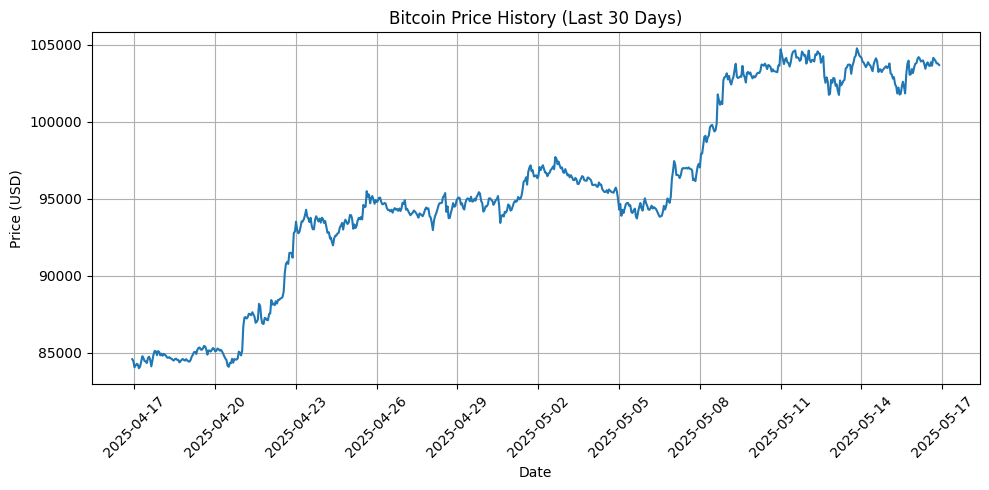

In [12]:

if len(df_history) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(df_history['timestamp'], df_history['price_usd'])
    plt.title(f'Bitcoin Price History (Last {day} Days)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    
    # Format x-axis dates clearly for better visibility
    import matplotlib.dates as mdates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Adjust tick spacing based on number of days
    if day <= 10:
        interval = 1  # Daily ticks for short periods
    elif day <= 30:
        interval = 3  # Every 3 days for medium periods
    else:
        interval = 7  # Weekly ticks for longer periods
        
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    _LOG.warning("Not enough data for visualization.")